# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
K = 50
N = 20

eps_psi_abs = 1e-4
eps_psi_rel = 1e-4

domain_tolerance = 1 / (10 * N)

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [4]:
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

In [5]:
h_s = 0
theta_m = theta_s
m = 1 - 1/n
L = 0.5

In [6]:
dt_D = 1/16
dt   = 1/48
T    = 3/16

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [7]:
psi_var = sp.Symbol('psi', negative=True)
theta_expression = theta_r + (theta_s - theta_r) / (1 + (-alpha * psi_var) ** n) ** m

theta_negative_func = sp.lambdify(psi_var, theta_expression, 'numpy')

In [8]:
effective_saturation = (theta_expression - theta_r) / (theta_s - theta_r)

hydraulic_conductivity_expression = K_s * (effective_saturation ** L) * ( 1 - (1 - effective_saturation ** (1 / m)) ** m ) ** 2
hydraulic_conductivity_negative_func = sp.lambdify(psi_var, hydraulic_conductivity_expression, 'numpy')

In [9]:
def theta(psi):
    mask = psi < h_s

    res = np.ones_like(psi) * theta_s
    res[mask] = theta_negative_func(psi[mask])

    return res

In [10]:
def hydraulic_conductivity_coefficient(psi):
    mask = psi < h_s

    res = np.ones_like(psi) * K_s
    res[mask] = hydraulic_conductivity_negative_func(psi[mask])

    return res

In [11]:
derivative_theta_negative_func = sp.lambdify(psi_var, sp.diff(theta_expression, psi_var), 'numpy')
derivative_inverse_hydraulic_conductivity_negative_func = sp.lambdify(psi_var, sp.diff(1 / hydraulic_conductivity_expression, psi_var), 'numpy')

In [12]:
def derivative_theta(psi):
    mask = psi < h_s
    res = np.zeros_like(psi)

    res[mask] = derivative_theta_negative_func(psi[mask])

    return res

In [13]:
def derivative_inverse_hydraulic_conductivity_coefficient(psi):
    mask = psi < h_s
    res = np.zeros_like(psi)

    res[mask] = derivative_inverse_hydraulic_conductivity_negative_func(psi[mask])

    return res

In [14]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    ax1.plot(psi_val, theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, 1 / hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K^-1")

    ax3.plot(psi_val, derivative_theta(psi_val))
    ax3.set_title("d theta / d psi")

    ax4.plot(psi_val, derivative_inverse_hydraulic_conductivity_coefficient(psi_val))
    ax4.set_title("d (K^-1) / d psi")


    plt.show()

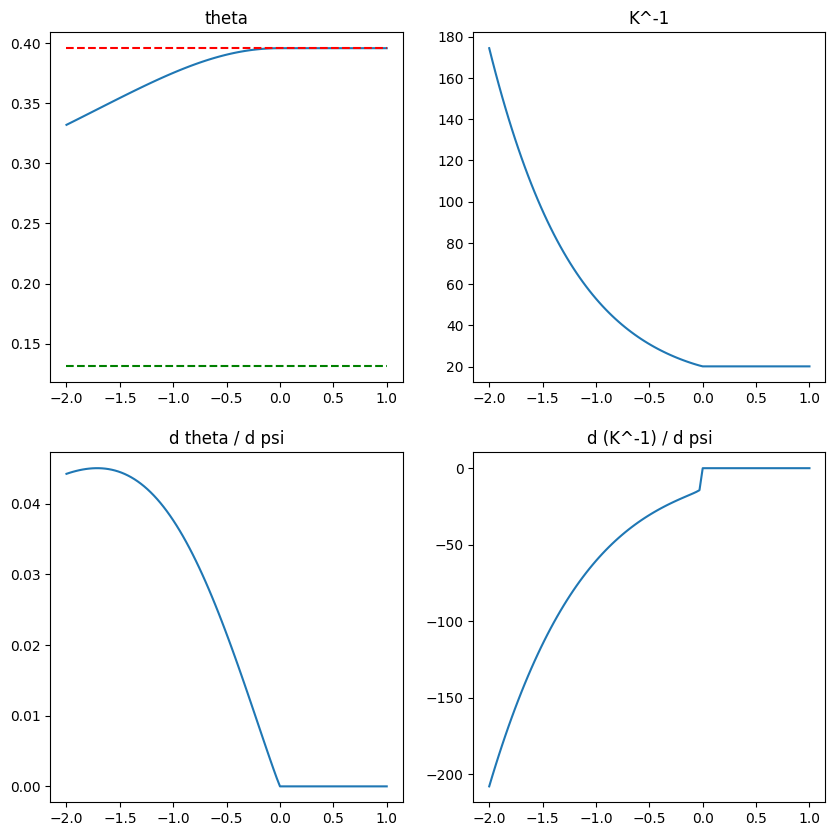

In [15]:
quick_plot()

### Domain preparation

In [16]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])
mdg.compute_geometry()

In [17]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [18]:
def g_func(x): 
    return np.array([0, -1, -1])

In [19]:
def initial_pressure_func(x): 
    return 1-x[1]

In [20]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] > 0-domain_tolerance, np.logical_and(subdomain.face_centers[0, :] < 1+domain_tolerance, subdomain.face_centers[1, :] > 3-domain_tolerance))
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] > 2-domain_tolerance, np.logical_and(subdomain.face_centers[1, :] > 0-domain_tolerance, subdomain.face_centers[1, :] < 1+domain_tolerance))

    gamma_d  = np.logical_or(gamma_d1, gamma_d2)
    
    gamma_n  = gamma_d.copy()
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    

    pp.initialize_data(subdomain, data, key, {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
    })
    
    def bc_gamma_d(x, t):
        if   x[0] > 2-domain_tolerance and x[1] > 0-domain_tolerance and x[1] < 1+domain_tolerance:
            res =  1 - x[1]
        elif x[1] > 3-domain_tolerance and x[0] > 0-domain_tolerance and x[0] < 1+domain_tolerance:
            res = min( 0.2, -2 + 2.2 * t / dt_D )
        else:
            res = 0
        
        return res

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q^{n+1}} + \nabla \psi^{n+1} = -\nabla z\\
\frac{\theta (\psi^{n+1}) - \theta (\psi^{n})}{\Delta t} + \nabla \cdot {q^{n+1}} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$


$$
Netwon \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + [B^T + C(\psi_k^{n+1}, q_ {k}^{n+1})] \psi^{n+1}_{k+1} = G^{n+1} + C(\psi_k^{n+1}, q_ {k}^{n+1}) \psi_k^{n+1} + BC^{n+1}\\
D(\psi_{k}^{n+1}) \psi_{k+1}^{n+1} - \Delta t B q_{k+1}^{n+1} = \Theta^n - \Theta^{n+1}_k + D(\psi_{k}^{n+1}) \psi_{k}^{n+1} + \Delta t F^{n+1}
\end{array}
\end{array}
\right.
$$

where:
$$
[M^{n+1}_k]_{ij} = \left( K^{-1}(\psi^{n+1}_k) \Phi_j, \Phi_i \right)_{L^2(\Omega)}, \qquad [C(\psi_k^{n+1}, q_ {k}^{n+1})]_{ij} = \int_{\Omega} \Psi_j \frac{\partial K^{-1}(\psi_k^{n+1})}{\partial \psi} \, q_k^{n+1} \cdot \Phi_i \, d\Omega, \qquad [D(\psi_{k}^{n+1})]_{ij} = \left( \frac{\partial \theta}{\partial \psi}(\psi_k^{n+1}) \Psi_j, \Psi_i \right)_{L^2(\Omega)}, \qquad [B]_{ij} = - \left( \Psi_i, \nabla \cdot \Phi_j \right)_{L^2(\Omega)}
$$

In [21]:
B = - P0.assemble_mass_matrix(subdomain) @ pg.div(mdg)

In [22]:
dof_p, dof_q = B.shape
dof_psi = dof_p

In [23]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)


def export_step(save, current_sol, step) -> None:
    q   = current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    ins = list()

    ins.append((subdomain, "cell_q", ( proj_q @ q).reshape((3, -1), order="F")))
    ins.append((subdomain, "cell_p", proj_psi @ psi))
    
    save.write_vtu(ins, time_step=step)

In [24]:
def project_array_to_P0(val):
    return val * subdomain.cell_volumes

In [25]:
sd = subdomain

size_HB = sd.dim * (sd.dim + 1)
HB = np.zeros((size_HB, size_HB))
for it in np.arange(0, size_HB, sd.dim):
    HB += np.diagflat(np.ones(size_HB - it), it)
HB += HB.T
HB /= sd.dim * sd.dim * (sd.dim + 1) * (sd.dim + 2)
    
deviation_from_plane_tol = data.get("deviation_from_plane_tol", 1e-5)
c_centers, f_normals, f_centers, R, dim, node_coords = pp.map_geometry.map_grid(sd, deviation_from_plane_tol)

faces, cells, sign = sps.find(sd.cell_faces)
index = np.argsort(cells)
faces, sign = faces[index], sign[index]

RT0._compute_cell_face_to_opposite_node(subdomain, data)
cell_face_to_opposite_node = data["rt0_class_cell_face_to_opposite_node"]

size_A = np.power(sd.dim + 1, 1) * sd.num_cells

def mixed_matrix(psi, q):
    cond_inv_coeff = derivative_inverse_hydraulic_conductivity_coefficient(psi)

    rows_A = np.empty(size_A, dtype=int)
    cols_A = np.empty(size_A, dtype=int)
    data_A = np.empty(size_A)
    idx_A = 0

    data[pp.PARAMETERS].update({"second_order_tensor": np.ones(sd.num_cells)})

    for c in np.arange(sd.num_cells):
        loc = slice(sd.cell_faces.indptr[c], sd.cell_faces.indptr[c + 1])
        faces_loc = faces[loc]
        
        node = cell_face_to_opposite_node[c, :]
        coord_loc = node_coords[:, node]

        A = pp.RT0.massHdiv(
            np.eye(sd.dim),
            sd.cell_volumes[c],
            coord_loc,
            sign[loc],
            sd.dim,
            HB,
        )

        q_loc = q[faces_loc]

        partial_C = A @ q_loc

        # Save values for Hdiv-mass local matrix in the global structure
        loc_idx = range(idx_A, idx_A + sd.dim + 1)
        rows_A[loc_idx] = faces_loc
        cols_A[loc_idx] = c
        data_A[loc_idx] = partial_C.ravel() * cond_inv_coeff[c] #/ sd.cell_volumes[c]
        
        idx_A += (sd.dim + 1)

    return sps.coo_matrix((data_A, (rows_A, cols_A)))

In [26]:
Mass_psi =  P0.assemble_mass_matrix(subdomain)

def newton(sol_n, t_n_1, prev=None, iters=K, debug=False):
    if prev == None:
        prev = sol_n.copy()

    # Assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Theta^n
    fixed_rhs[-dof_psi:] += Mass_psi @ project_array_to_P0(theta(proj_psi @ prev[-dof_psi:]))

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    if debug:
        save_debug = pp.Exporter(mdg, "sol_" + str(t_n_1), folder_name=output_directory + "/debug")
        export_step(save_debug, prev, 0)

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):
        psi = prev[-dof_psi:]
        q   = prev[:dof_q]

        rhs = None
        rhs = fixed_rhs.copy()

        C = mixed_matrix(proj_psi @ psi, q)

        rhs[:dof_q]    += C @ psi


        # Theta^{n+1}_k
        rhs[-dof_psi:] -= Mass_psi @ project_array_to_P0(theta(proj_psi @ psi))
        
        D = Mass_psi @ np.diag(derivative_theta(proj_psi @ psi))
        rhs[-dof_psi:] += D @ psi

        data[pp.PARAMETERS].update({"second_order_tensor": pp.SecondOrderTensor(hydraulic_conductivity_coefficient(proj_psi @ psi))})

        # construct the local matrices
        M_k_n_1 = None
        M_k_n_1 = pg.face_mass(mdg)

        
        spp = sps.bmat([[M_k_n_1, (B.T + C)], 
                        [-dt * B,         D]], format="csc")
        

        
        # solve the problem
        ls = None
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()

        if debug:
            export_step(save_debug, current, k+1)


        abs_err_psi  = np.sqrt(np.sum(np.power(current[-dof_psi:]-prev[-dof_psi:], 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(prev[-dof_psi:], 2)))


        print('Iteration #' + format(k+1, '0' + str(ceil(log10(iters)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / eps_psi_abs)) + 4) 
                                                     + '.' + str(ceil(log10(1 / eps_psi_abs)) + 4) + 'f'))

        if abs_err_psi < eps_psi_abs + eps_psi_rel * abs_err_prev:
            print('')
            return current
        else:
            prev = current
            
    return current

In [27]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [28]:
# assemble initial solution
initial_solution = np.zeros(dof_q + dof_psi)
initial_solution[-dof_psi:] += np.hstack(initial_pressure)

In [29]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( newton(sol[-1], step * dt, debug=True) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.02083


Iteration #001, error L2 relative psi:    0.01619449
Iteration #002, error L2 relative psi:    0.00031708
Iteration #003, error L2 relative psi:    0.00000158

Time 0.04167
Iteration #001, error L2 relative psi:    0.02366703
Iteration #002, error L2 relative psi:    0.00146544
Iteration #003, error L2 relative psi:    0.00000460

Time 0.0625
Iteration #001, error L2 relative psi:    0.03167990
Iteration #002, error L2 relative psi:    0.00674913
Iteration #003, error L2 relative psi:    0.00019309
Iteration #004, error L2 relative psi:    0.00000092

Time 0.08333
Iteration #001, error L2 relative psi:    0.01843740
Iteration #002, error L2 relative psi:    0.00218904
Iteration #003, error L2 relative psi:    0.00002502

Time 0.10417
Iteration #001, error L2 relative psi:    0.00569963
Iteration #002, error L2 relative psi:    0.00027243
Iteration #003, error L2 relative psi:    0.00000028

Time 0.125
Iteration #001, error L2 relative psi:    0.00112354
Iteration #002, error L2 relativ